## Setup

In [1]:
import os
import pathlib
import warnings

import cv2
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from skimage.restoration import (
    denoise_tv_chambolle,
    denoise_bilateral,
    denoise_wavelet,
    estimate_sigma,
)
from skimage import data
from skimage.util import random_noise

from matplotlib import animation
from IPython.display import display, HTML

from src.utils import plot_batch, implot

warnings.simplefilter("ignore")

Tensorflow's dominance over numpy is usage of tensors, which (in short) allows to dirstibute computation to gpu, which is better suited for muliplying large matrices, therefore leads to faster computation and allows to deal with more data at once.

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [3]:
DATA_DIR = os.path.join(os.path.abspath(os.curdir), "data")
os.makedirs(DATA_DIR, exist_ok=True)

## Downloading data

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

archive = tf.keras.utils.get_file(origin=dataset_url, extract=True, cache_dir=DATA_DIR)
data_dir = pathlib.Path(archive).with_suffix("")

## Creating dataset

In [5]:
batch_size = 32
img_height = 180
img_width = 180
seed = 42

In [6]:
def get_ds(data_dir: pathlib.Path, subset: str) -> tf.data.Dataset:
    return tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset=subset,
        seed=seed,
        # image_size=(img_height, img_width),
        batch_size=batch_size,
    )


train_ds = get_ds(data_dir, "training")
val_ds = get_ds(data_dir, "validation")

class_names = train_ds.class_names
print("\nClasses: " + ", ".join(class_names))

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.

Classes: daisy, dandelion, roses, sunflowers, tulips


rebatch - overwrites batch size take - take one batch - in below case it will return Tensor of shape [9, img_height img_width, 3]. 3 stands for rgb format

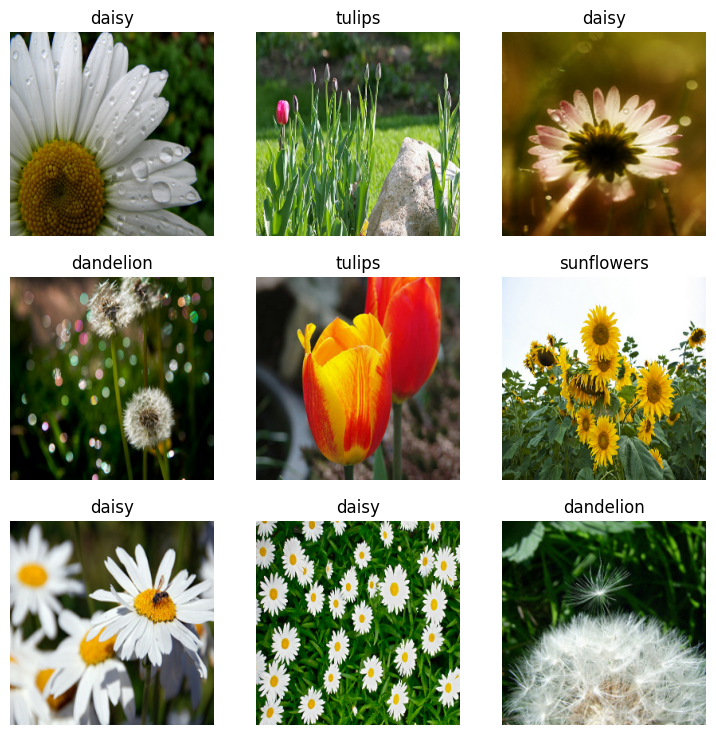

In [7]:
for x, y in train_ds.rebatch(9).take(1):
    plot_batch(x, labels=y, class_names=class_names, ncols=3)

## Image resizing and rescalling

Probably most commonly used operations on images are rescaling their pixel values to range <0, 1> (that's because most of models achiche better scores on these type of data distribution) and photo resizing - working with high resolution images is extremely expensive, for most usecases downcasting them to lower resolution will preserve enough information to produce acceptable results.

In [8]:
img, label = train_ds.rebatch(1).take(1).__iter__().__next__()
img.shape

TensorShape([1, 256, 256, 3])

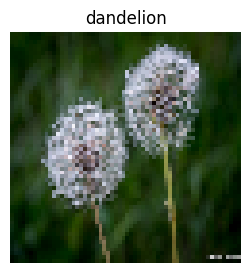

In [9]:
def nearest(img: np.ndarray, width: int, height: int) -> np.ndarray:
    s = np.array([height / img.shape[0], width / img.shape[1]])
    r = np.empty([height, width, img.shape[2]], dtype=img.dtype)

    for i in range(height):
        for j in range(width):
            r[i, j] = img[int(i / s[0]), int(j / s[1])]
    return r


resized_img = nearest(img[0].numpy(), 60, 60)
plot_batch(
    resized_img[np.newaxis, :, :, :],
    labels=label,
    class_names=class_names,
    figsize=(3, 3),
)

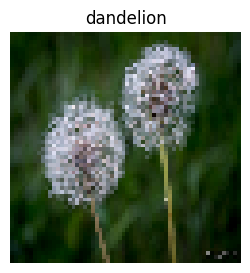

In [10]:
resized_img_tensorflow = layers.Resizing(60, 60, "nearest")(img)
plot_batch(
    resized_img_tensorflow, labels=label, class_names=class_names, figsize=(3, 3)
)

mean pixel difference between our and tensorflow implementation

In [11]:
np.mean(np.abs(resized_img - resized_img_tensorflow.numpy()[0]))

14.681442

Image resizing - interpolation

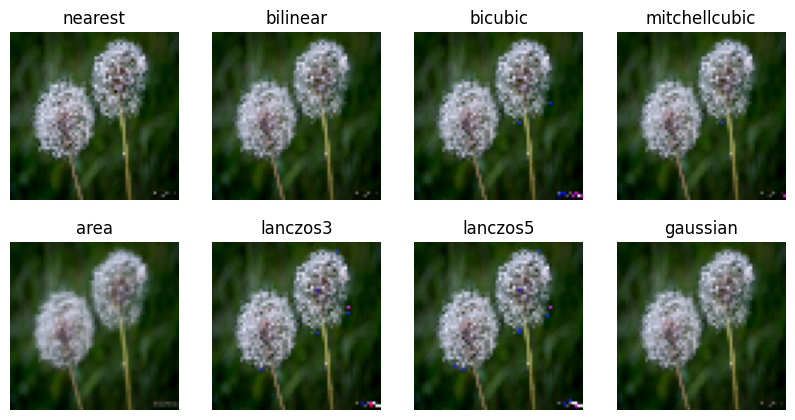

In [12]:
def deomnostrate_interpolation(names):
    resized_imgs_tensorflow = [
        layers.Resizing(60, 60, name)(img)[0].numpy() for name in names
    ]
    plot_batch(np.stack(resized_imgs_tensorflow), names=names, figsize=(10, 5), ncols=4)


# https://www.tensorflow.org/api_docs/python/tf/image/resize
# https://pixinsight.com/doc/docs/InterpolationAlgorithms/InterpolationAlgorithms.html
deomnostrate_interpolation(
    [
        # O(n*m)
        # good to use for real-time interpolation thus it's fastest
        "nearest",
        # https://theailearner.com/2018/12/29/image-processing-nearest-neighbour-interpolation/
        # O(4 * n*m)
        # default, takes into consideration 2x2 nearest neighbours and resulting pixel will
        # be weighted mean of their values, where weight is defined by distance to the pixel
        # results in smoother image than nearest,
        "bilinear",
        # https://theailearner.com/2018/12/29/image-processing-bilinear-interpolation/
        # https://en.wikipedia.org/wiki/Bilinear_interpolation
        # O(16 * n*m)
        # takes into consideration 4x4 nearest neighbours (note: this requires padding).
        # Prodices sharper images, but may cause cropping (which is not nessesarly bad)
        # good to use when dealing with photographs / images of natural scenes
        "bicubic",
        # https://theailearner.com/2018/12/29/image-processing-bicubic-interpolation/
        # https://en.wikipedia.org/wiki/Bicubic_interpolation
        # ~O(n*m^2)
        # takes into consideration 4x4 nearest neighbours, maintain better balance between
        # sharpness and bluriness, here B=C=1/3
        # good when we want natural-looking details
        "mitchellcubic",
        # https://en.wikipedia.org/wiki/Mitchell–Netravali_filters
        # O(n * m) - O(n^2 * m^2) - it depends on how many pixels we take into consideration
        # only for downcasting, usually fast - depends on how many pixels we consider at once
        # produces rather pixelised, low quality images
        # good for signiphicant downscalling, bad for upscalling
        "area",
        # O(n * m * 4 * a^2)
        # produces most charp images
        # good to use with images with sharp edges / text / fine textures
        "lanczos3",
        "lanczos5",
        # https://en.wikipedia.org/wiki/Lanczos_resampling
        # https://mazzo.li/posts/lanczos.html
        "gaussian"
        # https://en.wikipedia.org/wiki/Normal_distribution
        # good to use when we expect rater artiscic effect, without sharp edges
    ]
)

Final shape - (180, 180, 3), (min, max) pixel values - (0.0, 0.98812336)


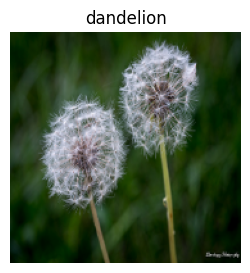

In [13]:
resize_and_rescale = keras.Sequential(
    [
        layers.Resizing(img_height, img_width, crop_to_aspect_ratio=False),
        layers.Rescaling(1.0 / 255),
    ]
)

processed_img = resize_and_rescale(img)
plot_batch(
    processed_img, labels=label, class_names=class_names, figsize=(3, 3), float_=True
)
print(
    f"Final shape - {processed_img[0].shape}, (min, max) pixel values - {np.min(processed_img), np.max(processed_img)}"
)

## Image filtering

Covered in different [notebook](./src/filtering.ipynb)

## Data augumentation

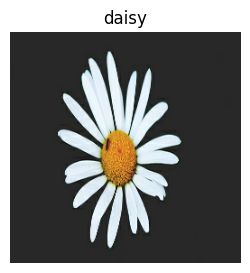

In [14]:
x, y = train_ds.rebatch(1).take(1).__iter__().next()
x_numpy = x.numpy()
plot_batch(x_numpy, labels=y, class_names=class_names)

Converting to grayscale

(256, 256)


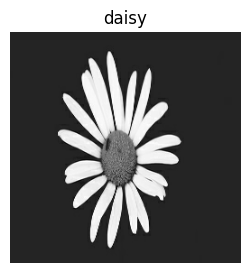

In [15]:
x_new = cv2.cvtColor(x_numpy[0], cv2.COLOR_BGR2GRAY)
plot_batch(x_new[np.newaxis, ...], labels=y, class_names=class_names, cmap="gray")
print(x_new.shape)  # now it has just one channel

Map all pixels greater than thresshold to 255, rest to 0 on each channel

100.0
[  0. 255.]


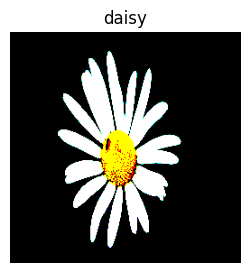

In [16]:
ret, x_new = cv2.threshold(x_numpy[0], 100, 255, cv2.THRESH_BINARY)
print(ret)  # used threshold
print(np.unique(x_new))  # just 0 and 255
plot_batch(x_new[np.newaxis, ...], labels=y, class_names=class_names)

In [17]:
np.max(x_numpy)

255.0

Data autugmentation using tensorflow and keras

In [18]:
class RandomInvert(layers.Layer):
    def __init__(self, factor=0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor

    def call(self, x):
        if tf.random.uniform([]) < self.factor:
            return 255 - x
        return x


class RandomAdjustSaturation(layers.Layer):
    def __init__(self, factor=0.5, saturation_factor=4, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor
        self.saturation_factor = saturation_factor

    def call(self, x):
        if tf.random.uniform([]) < self.factor:
            return tf.image.adjust_saturation(x, self.saturation_factor)
        return x


class RandomStandarizeImage(layers.Layer):
    def __init__(self, factor=0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor

    def call(self, x):
        if tf.random.uniform([]) < self.factor:
            return (
                tf.image.per_image_standardization(x) * 255
            )  # *255 only for it to be visable on plot, it doesn't make sense
        return x

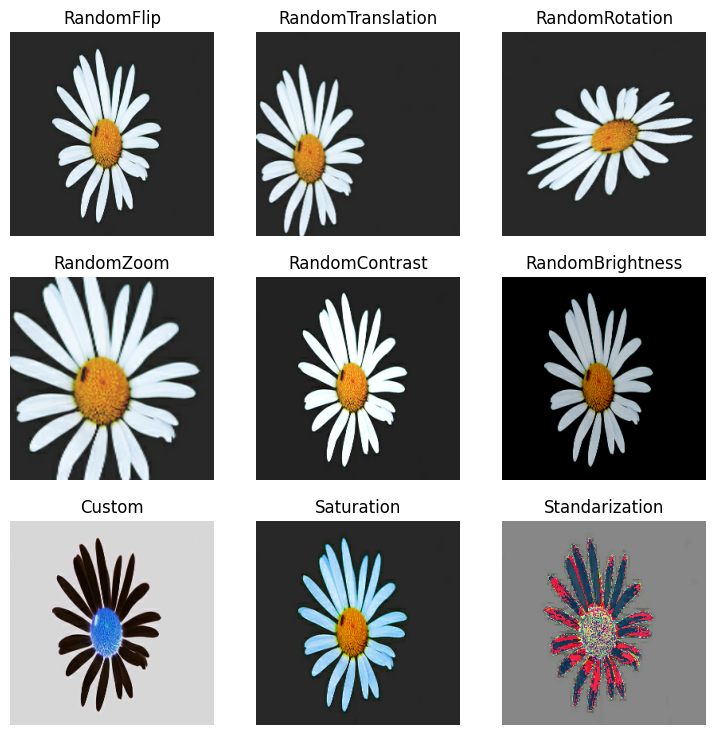

In [19]:
# https://www.tensorflow.org/api_docs/python/tf/image
# https://keras.io/api/layers/preprocessing_layers/image_augmentation/

translate = lambda layer: layer(x_numpy).numpy().astype(np.uint8)[0]

implot(
    [
        translate(layer)
        for layer in [
            # layers.RandomCrop(200, 200, seed=42),
            layers.RandomFlip(seed=42),
            layers.RandomTranslation(
                (-0.3, 0.2), (-0.4, 0.1), seed=42, fill_mode="reflect"
            ),
            layers.RandomRotation((-0.3, 0.5), seed=42),
            layers.RandomZoom((-0.2, -0.3), (-0.4, -0.5), seed=42),  # - for zooming in
            layers.RandomContrast(
                (0.0, 0.7), seed=42
            ),  # choose between 1.0 - 0., 1.0 + 0.7
            layers.RandomBrightness((-0.5, -0.1), seed=42),
            RandomInvert(factor=1.0),
            RandomAdjustSaturation(factor=1.0),
            RandomStandarizeImage(factor=1.0),
        ]
    ],
    cols=3,
    names=[
        "RandomFlip",
        "RandomTranslation",
        "RandomRotation",
        "RandomZoom",
        "RandomContrast",
        "RandomBrightness",
        "Custom",
        "Saturation",
        "Standarization",
    ],
)

We can use this easier in build-in generator

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
https://medium.com/analytics-vidhya/understanding-image-augmentation-using-keras-tensorflow-a6341669d9ca

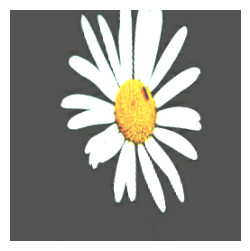

In [20]:
adjust_saturation = lambda x: tf.image.adjust_saturation(x, 4)

datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,  # Random rotation within the range [-40, 40] degrees
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    # Random shear transformation - it fixes one axis and moves pixels on second axis by factor,
    # than fixes second axis and moves pixels on fist axis by factor
    shear_range=0.2,
    zoom_range=0.2,  # Random zoom in/out
    horizontal_flip=True,  # Random horizontal flip
    brightness_range=(0, 2),  # brightness 0 - dark, 2 - 2 times lighter
    rescale=1 / 255,
    preprocessing_function=adjust_saturation,  # custom function
    channel_shift_range=100,
    fill_mode="reflect",
)

implot(
    [
        datagen.apply_transform(
            x_numpy[0], datagen.get_random_transform(x_numpy.shape, seed=42)
        ).astype(np.uint8)
    ]
)

Found 3670 images belonging to 5 classes.


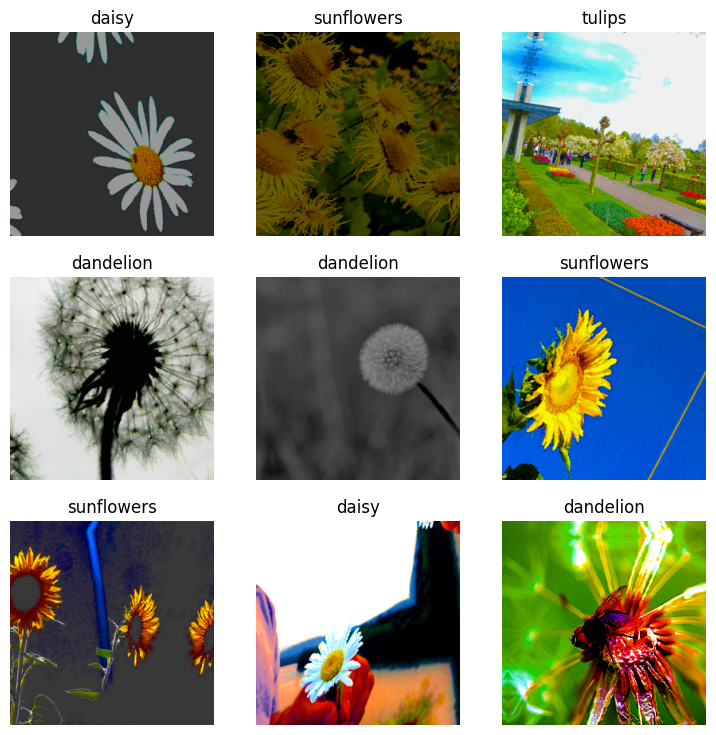

In [21]:
generator = datagen.flow_from_directory(data_dir, batch_size=9, seed=42)
(x, y) = generator.__next__()

plot_batch(
    x,
    class_names=class_names,
    labels=[list(r).index(1) for r in y],
    ncols=3,
    float_=True,
)

## Denoising

In [22]:
def add_gaussian_noise(image, mean=0, std=12):
    noise = np.random.normal(mean, std, image.shape).astype(np.float32)
    noisy_image = cv2.add(image, noise)
    # for c in range(image.shape[-1]):
    #     noisy_image[:, :, c] = MinMaxScaler(feature_range=(0, 255)).fit_transform(noisy_image[:, :, c])
    return noisy_image.astype(np.uint8)


x_numpy_noise = add_gaussian_noise(x_numpy[0])

Below are just some most simple deniosers, for better resuilts one might want to use ml-based solitions, they however usually require much more computation.

In [23]:
denoise = lambda img: [
    img,
    # https://en.wikipedia.org/wiki/Total_variation_denoising
    denoise_tv_chambolle(img, weight=0.4, channel_axis=-1),
    denoise_tv_chambolle(img, weight=0.8, channel_axis=-1),
    # uses bilateral filter
    denoise_bilateral(img, sigma_color=0.1, sigma_spatial=5, channel_axis=-1),
    denoise_bilateral(img, sigma_color=0.2, sigma_spatial=15, channel_axis=-1),
    # https://en.wikipedia.org/wiki/Wavelet_transform
    denoise_wavelet(img, channel_axis=-1, rescale_sigma=True),
    denoise_wavelet(img, channel_axis=-1, convert2ycbcr=True, rescale_sigma=True),
    # http://www.ipol.im/pub/art/2011/bcm_nlm/article.pdf
    cv2.fastNlMeansDenoisingColored(
        img.astype(np.uint8), h=20, hColor=30, templateWindowSize=7, searchWindowSize=21
    ),
]
labels = [
    "noise",
    "tv_chambolle",
    "tv_chambolle stronger",
    "bilateral",
    "bilateral stronger",
    "wavelet",
    "wavelet (YCbCr colorspace)",
    "fastNlMeans",
]


def demonstrate_denoisers(img):
    denoised = denoise(img)
    for img, label in zip(denoised, labels):
        sigma_est = estimate_sigma(img, channel_axis=-1, average_sigmas=True)
        print(
            f"Estimated Gaussian noise standard deviation for '{label}' = {sigma_est}"
        )
    implot(denoised, labels, cols=4)

Estimated Gaussian noise standard deviation for 'noise' = 14.04167353310172
Estimated Gaussian noise standard deviation for 'tv_chambolle' = 0.0013483541348611652
Estimated Gaussian noise standard deviation for 'tv_chambolle stronger' = 0.002026719207499572
Estimated Gaussian noise standard deviation for 'bilateral' = 0.001786633184259342
Estimated Gaussian noise standard deviation for 'bilateral stronger' = 0.0025944221244450787
Estimated Gaussian noise standard deviation for 'wavelet' = 0.028346164779211452
Estimated Gaussian noise standard deviation for 'wavelet (YCbCr colorspace)' = 0.030587693429047685
Estimated Gaussian noise standard deviation for 'fastNlMeans' = 0.5785870850929437


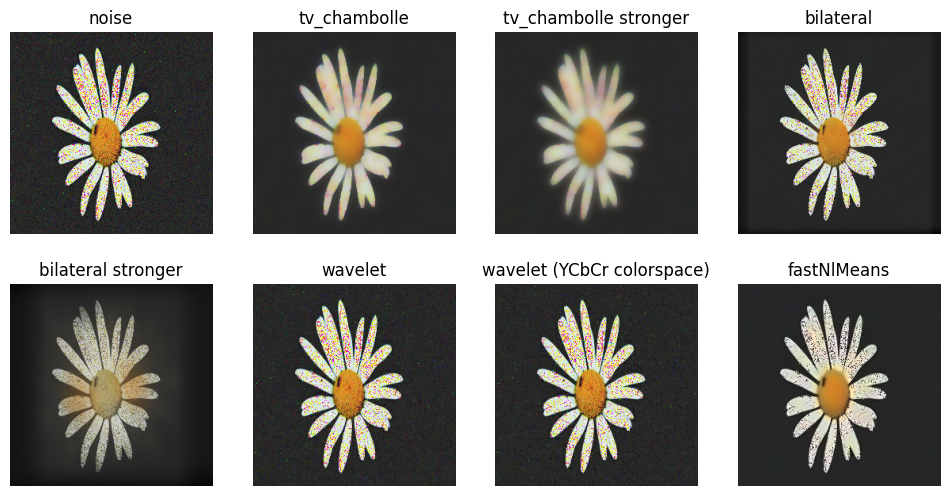

In [24]:
demonstrate_denoisers(x_numpy_noise)

Estimated Gaussian noise standard deviation for 'noise' = 38.36848057990113
Estimated Gaussian noise standard deviation for 'tv_chambolle' = 0.0017726124181319132
Estimated Gaussian noise standard deviation for 'tv_chambolle stronger' = 0.0014475595429823771
Estimated Gaussian noise standard deviation for 'bilateral' = 0.03800487918220884
Estimated Gaussian noise standard deviation for 'bilateral stronger' = 0.019593409713722486
Estimated Gaussian noise standard deviation for 'wavelet' = 4.889557340169049e-18
Estimated Gaussian noise standard deviation for 'wavelet (YCbCr colorspace)' = 0.0003843518475709234
Estimated Gaussian noise standard deviation for 'fastNlMeans' = 3.2420039307662107


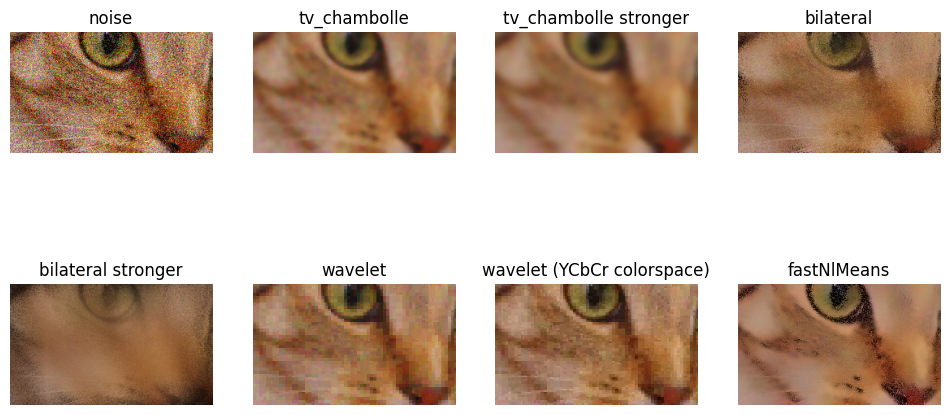

In [25]:
original = data.chelsea()[100:250, 50:300]
noisy = random_noise(original, var=0.155**2)
demonstrate_denoisers((noisy * 255).astype(np.uint8))

In [26]:
def create_rotation_movie(img):
    img = img[::2, ::2, :]
    fractions = np.linspace(0, 0.3, 60)
    return [
        layers.RandomRotation(
            (f, f), fill_mode="reflect", interpolation="bilinear", seed=seed
        )(img)
        .numpy()
        .astype("uint8")
        for f in fractions
    ]


noisy_images = create_rotation_movie(x_numpy_noise)

In [27]:
def plot_movie(imgs, fps=30, figsize=(2, 2), **kw):
    fig = plt.figure(figsize=figsize)

    def animate(i):
        plt.imshow(noisy_images[i].astype("uint8"))
        plt.axis("off")

    anim = animation.FuncAnimation(
        fig,
        animate,
        frames=len(imgs),
        interval=1000.0 / fps,
        repeat_delay=1000,
        repeat=True,
    )
    display(HTML(anim.to_html5_video()))
    plt.close()


plot_movie(noisy_images)

This will denoise image of index 9 using data from 4 images before it, this image and 4 images after it (i.e. 9 images from original image's neighborhood)

Estimated Gaussian noise standard deviation = 0.19966023740101857


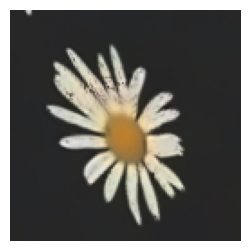

In [28]:
denoised = cv2.fastNlMeansDenoisingColoredMulti(
    noisy_images,
    imgToDenoiseIndex=15,
    temporalWindowSize=9,
    h=20,
    hColor=30,
    templateWindowSize=7,
    searchWindowSize=21,
)
sigma_est = estimate_sigma(denoised, channel_axis=-1, average_sigmas=True)
print(f"Estimated Gaussian noise standard deviation = {sigma_est}")

implot(denoised)

## Image blending

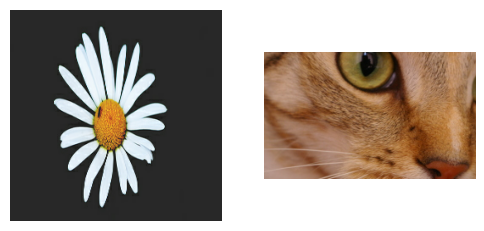

In [29]:
implot([x_numpy[0].astype(np.uint8), original], cols=2)

Case 1 - images are the same size

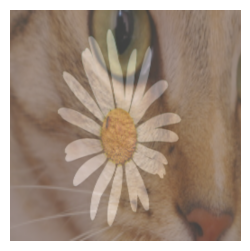

In [30]:
img1 = layers.Resizing(600, 600)(x_numpy[0].astype(np.uint8)).numpy().astype(np.uint8)
img2 = layers.Resizing(600, 600)(original).numpy().astype(np.uint8)

# src1 * aplha + src2 * beta + gamma
blended = cv2.addWeighted(src1=img1, alpha=0.3, src2=img2, beta=0.5, gamma=50)
implot([blended])

Case 2 - image sized do not match - put smaller image inside larger image

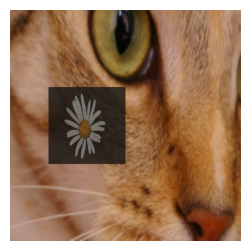

In [31]:
large_image = layers.Resizing(600, 600)(original).numpy().astype(np.uint8)
small_image = (
    layers.Resizing(200, 200)(x_numpy[0].astype(np.uint8)).numpy().astype(np.uint8)
)

x_offset = 200
y_offset = 100

large_image[
    x_offset : x_offset + small_image.shape[0],
    y_offset : y_offset + small_image.shape[1],
] = (
    small_image * 0.4
    + large_image[
        x_offset : x_offset + small_image.shape[0],
        y_offset : y_offset + small_image.shape[1],
    ]
    * 0.2
)
implot([large_image])

## dataset interface for performance boost

In [32]:
tfds.benchmark(train_ds)


************ Summary ************



  0%|          | 0/92 [00:00<?, ?it/s]

100%|██████████| 92/92 [00:02<00:00, 40.53it/s]

Examples/sec (First included) 40.77 ex/sec (total: 93 ex, 2.28 sec)
Examples/sec (First only) 3.43 ex/sec (total: 1 ex, 0.29 sec)
Examples/sec (First excluded) 46.24 ex/sec (total: 92 ex, 1.99 sec)


BenchmarkResult(stats=             duration  num_examples        avg
first+lasts  2.280838            93  40.774495
first        0.291424             1   3.431430
lasts        1.989414            92  46.244776, raw_stats=                       duration
start_time        178151.354794
first_batch_time  178151.646218
end_time          178153.635632
num_iter              92.000000)

In [33]:
train_ds.shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
tfds.benchmark(train_ds)


************ Summary ************



  0%|          | 0/92 [00:00<?, ?it/s]

100%|██████████| 92/92 [00:01<00:00, 48.21it/s]

Examples/sec (First included) 48.69 ex/sec (total: 93 ex, 1.91 sec)
Examples/sec (First only) 4.60 ex/sec (total: 1 ex, 0.22 sec)
Examples/sec (First excluded) 54.35 ex/sec (total: 92 ex, 1.69 sec)


BenchmarkResult(stats=             duration  num_examples        avg
first+lasts  1.910116            93  48.688135
first        0.217411             1   4.599591
lasts        1.692706            92  54.350855, raw_stats=                       duration
start_time        178153.667931
first_batch_time  178153.885342
end_time          178155.578048
num_iter              92.000000)

This can be further speeded up and customized - refer to [documentation](https://www.tensorflow.org/datasets/decode#only_decode_a_sub-set_of_the_features)